(512, 512)
(512, 512)


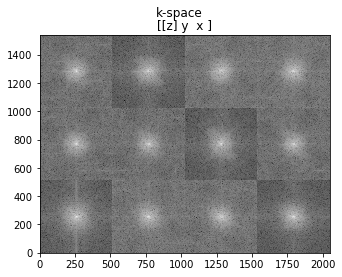

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

(12, 512, 512)


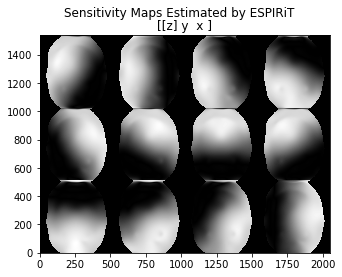

Done!


In [1]:
from matplotlib import pyplot as plt, cm
import numpy as np
import SimpleITK as sitk
import glob, os
import cv2, h5py
from PIL import Image, ImageEnhance
from PIL.Image import fromarray
import pydicom
import sigpy as sp
import sigpy.plot as pl
import sigpy.mri as mr
from pydicom.pixel_data_handlers.util import apply_voi_lut

def makeCSM(path, num_of_coils = 12):
#path is just the path of the jpeg you'll be passing through after you create it from the dicom. 
    
    gradient_magnitude = 1.2
    faded_arr = []
    iteration_angle = 360/(num_of_coils)
    
    for i in range(num_of_coils):
        im = Image.open(path).convert("L").rotate(270+(i*iteration_angle))
        if im.mode != 'RGBA':
            im = im.convert('RGBA')
        width, height = im.size
        gradient = Image.new('L', (width, 1), color=0xFF)
        for x in range(width):
            # gradient.putpixel((x, 0), 255-x)
            gradient.putpixel((x, 0), int(255 * (1.2 - gradient_magnitude * float(x)/width)))
        alpha = gradient.resize(im.size)
        black_im = Image.new('RGBA', (width, height), color=0) # i.e. black
        black_im.putalpha(alpha)
        gradient_im = Image.alpha_composite(im, black_im)

        #increases contrast of image
        enhancer = ImageEnhance.Contrast(gradient_im)
        gradient_im = enhancer.enhance(2.5)

        #converts image to greyscale
        gradient_im = gradient_im.convert('L').rotate(90-(i*iteration_angle))
        
        #creates numpy array from image
        np_arr = np.array(gradient_im)
        
        #FFT conversion
        img_fft = np.fft.fftshift(np_arr)
        img_fft = np.fft.fft2(img_fft)
        
        #pushes each image np.array into larger array
        if i == 0:
            faded_arr = np.expand_dims(img_fft, axis = 0)
        else:
            faded_arr = np.append(faded_arr, np.expand_dims(img_fft, axis = 0), axis = 0)
    
            
    #here begins CSM estimations - prepares FFT for CSM esitmation
    ksp = faded_arr
    temp = []

    for i in range(num_of_coils):
        ksp_arr = []
        ksp_arr = ksp[i]
        ksp_arr = np.fft.fftshift(ksp[i])
        if i == 0:
            temp = np.expand_dims(ksp_arr, axis = 0)
        else:
            temp = np.append(temp, np.expand_dims(ksp_arr, axis = 0), axis = 0)

    ksp = temp
        
    #plots the k-spaces 
    pl.ImagePlot(ksp, mode='l', z=0, title='k-space')
        
    mps = mr.app.EspiritCalib(ksp).run()
    
    print(mps.shape)

    pl.ImagePlot(mps, z=0, title='Sensitivity Maps Estimated by ESPIRiT')
            
        #prints image out
        #following commented code is only for diagnosis
        
#         plt.imshow(img_fft.astype("float64"))
#         plt.show()
        
#         #prints shape
#         print(np_arr.shape)

#         #saves image as file
#         gradient_im.save('C:/Users/Kevin/Desktop/old/test/out' + str(i) + '.png', 'PNG')

    return mps


DATA_DIR = "C:/Users/Kevin/Desktop/old/test_512.jpg"
DATA_DIR_MASK = "C:/Users/Kevin/Desktop/old/test_512_mask.jpeg"

plot = lambda x: plt.imshow(x,cmap=plt.cm.gray, clim=(0.0, .8))

image = Image.open(DATA_DIR).convert('L')
image_final = np.asarray(image) #idk if the next functions will overwrite this so I will just create it again.
print(image_final.shape)
image_mask = Image.open(DATA_DIR_MASK).convert('L')
image_mask = np.asarray(image_mask)
print(image_mask.shape)
tstOrgData = np.expand_dims(image_final, axis = 0)
tstMaskData = np.expand_dims(image_mask, axis = 0)

tstCsmData = np.expand_dims(makeCSM(DATA_DIR),axis = 0)



outFilename = 'demoImage.hdf5'  # The name of our HDF5 data file

with h5py.File(outFilename, 'w') as df:  # Open hdf5 file for writing our DICOM dataset
    
    c8_datatype = np.dtype('<c8')
    i1_datatype = np.dtype('|i1')
    
    dset = df.create_dataset('tstOrg', data=tstOrgData.astype(c8_datatype), shape=(1,512,512), maxshape=(None,512,512))
    dset = df.create_dataset('tstCsm', data=tstCsmData.astype(c8_datatype), shape=(1,12,512,512), maxshape=(None, None,512,512))
    dset = df.create_dataset('tstMask',data=tstMaskData.astype(i1_datatype), shape=(1,512,512), maxshape=(None,512,512))
    
    print("Done!")



    


